In [2]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_io as tfio
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
settings.init()
from tensorflow import keras
from tensorflow.keras import layers
tf.autograph.set_verbosity(0, False)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental_run_functions_eagerly(True)

print("\nTensorflow report:")
print("Devices:", tf.config.list_physical_devices('GPU'))
print("Version:", tf.__version__)

TRAIN_DATA_LEN: 3714569
VAL_DATA_LEN: 1590319
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.

Tensorflow report:
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version: 2.3.1


In [20]:
sample_rate = 48000
window_time = 22
frame_length = int(48000*window_time/1000)
frame_step = frame_length//4
from modules.DataPreprocessor import DataLoader
dl = DataLoader()

def load_audio_binary(path):
    audio_binary = tf.io.read_file(path)
    audio = tfio.audio.decode_mp3(audio_binary)
    return audio[:, 0]


def make_spectrogram(audio):
    audio = audio.numpy()
    audio_spec = librosa.feature.melspectrogram(audio,
                                                sr=sample_rate,
                                                n_fft=frame_length,
                                                hop_length=frame_step,
                                                n_mels=128)
    db_audio_spec = librosa.power_to_db(audio_spec,
                                        ref=1.0,
                                        top_db=80.0)
    return db_audio_spec


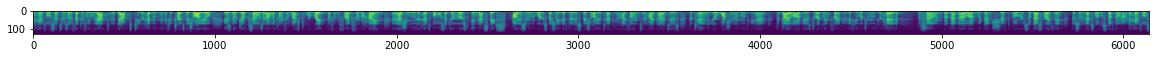

In [63]:
path = r'C:\Users\skaya\Downloads\y2.mp3'
audio = load_audio_binary(path)
audio = dl.cut_voice(audio)
spec = make_spectrogram(audio)
paded_spec = dl.pad_spec(spec)
specs_batch = []
# windowing spectrograms
for window in np.arange(0, paded_spec.shape[1]-128, 128):
    spec_window = paded_spec[:, window:window + 256]
    specs_batch.append(spec_window)
batch = np.expand_dims(np.array(specs_batch), axis=-1)
batch = np.repeat(batch, 3, axis=-1)
batch_tensor = tf.convert_to_tensor(batch)
batch_tensor = (batch_tensor-tf.math.reduce_min(batch_tensor))/(tf.math.reduce_max(batch_tensor)-tf.math.reduce_min(batch_tensor))
model = tf.keras.models.load_model('saved_models\checkpoints\model_log12_10_2020_03_33.h5')
pred_y = model.predict(batch_tensor)
b = np.zeros_like(pred_y)
b[np.arange(len(pred_y)), pred_y.argmax(1)] = 1
fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow(paded_spec)

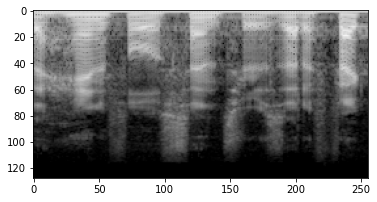

In [64]:
plt.imshow(batch_tensor[0,:,:,:])

In [66]:
print('med:', np.median(b.argmax(1)))
final_pred = (pred_y*100).mean(axis=0)
print('10-20 lat: {:.2f}%'.format(final_pred[0]))
print('20-30 lat: {:.2f}%'.format(final_pred[1]))
print('30-40 lat: {:.2f}%'.format(final_pred[2]))
print('40-50 lat: {:.2f}%'.format(final_pred[3]))
print('50-60 lat: {:.2f}%'.format(final_pred[4]))
print('60-70 lat: {:.2f}%'.format(final_pred[5]))
print('70-80 lat: {:.2f}%'.format(final_pred[6]))
print('80-90 lat: {:.2f}%'.format(final_pred[7]))

med: 2.0
10-20 lat: 4.06%
20-30 lat: 2.67%
30-40 lat: 51.13%
40-50 lat: 31.66%
50-60 lat: 10.46%
60-70 lat: 0.02%
70-80 lat: 0.00%
80-90 lat: 0.00%


2.0